In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *

In [2]:
all_xray_df = pd.read_csv('../input/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
95684,00025168_001.png,No Finding,1,25168,69,F,AP,3056,2544,0.139,0.139,NaN,../input/images_011/images/00025168_001.png
94395,00024173_000.png,No Finding,0,24173,31,M,PA,2530,2725,0.143,0.143,NaN,../input/images_010/images/00024173_000.png
72895,00017972_002.png,No Finding,2,17972,15,M,AP,3056,2544,0.139,0.139,NaN,../input/images_008/images/00017972_002.png


In [3]:
src=all_xray_df[['path','Finding Labels']]
src=src.rename(index=str, columns={"path": "path", "Finding Labels": "labels"})

In [4]:
import re
pattern='.*Pneumothorax.*'
pattern=re.compile(pattern)

In [5]:
none=src[(src.labels == 'No Finding')]
pneumo=src[src.labels.str.match('.*Pneumothorax.*')]

In [6]:
np.random.seed(10)
remove_n = 55000
drop_indices = np.random.choice(none.index, remove_n, replace=False)
none = none.drop(drop_indices)

In [7]:
src=pd.concat([none,pneumo],axis=0,sort=False)

In [8]:
bs=16

In [9]:
import cv2
def custom_transform(x): # you get a PyTorch tensor as input, not a fastai Image object
    npim = image2np(x)*255 # convert to numpy array in range 0-255
    npim = npim.astype(np.uint8) # convert to int
	
    # If your image is a regular colour image, remember it will be in RGB so convert to BGR if needed
    img_bgr = cv2.cvtColor(npim, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(img_bgr)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    cl=clahe.apply(l_channel)
    merged_channels = cv2.merge((cl, a_channel, b_channel))
    final_image = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2RGB)
    # transform using opencv
    # ...
    # don't forget to convert back to RGB if needed
    # assuming result image is stored in result_img
    return pil2tensor(final_image, dtype=np.float32)/255 # convert back to tensor and return

custom_trans = TfmPixel(custom_transform) # wrap in TfmPixel to create a valid transform

In [10]:
tfms=([*rand_pad(2,1024,mode='zeros'),rand_zoom(1.3,1.5),rand_crop(padding_mode='zeros'),custom_trans()],[])

In [11]:
data=(ImageList.from_df(src,'/kaggle/working',cols=0)
    .split_by_rand_pct(0.1)
    .label_from_df(label_delim='|')
    .transform(tfms,size=1024)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
    )

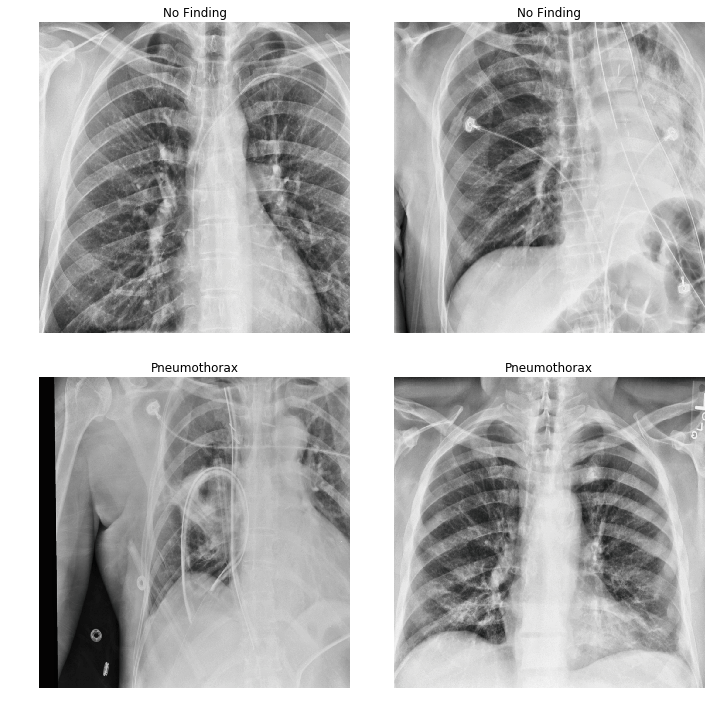

In [12]:
data.show_batch(2,figsize=(10,10))

In [13]:
learner = cnn_learner(data,models.resnet34 ,metrics=accuracy_thresh,model_dir='/kaggle')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 70805637.02it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


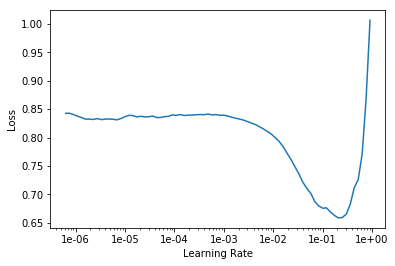

In [14]:
learner.lr_find()
learner.recorder.plot()

In [15]:
lr=2e-2

In [16]:
learner.fit_one_cycle(4,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.190453,0.190338,0.930207,22:13
1,0.189545,0.307245,0.925704,21:10
2,0.169200,0.713468,0.931645,20:57
3,0.165118,0.420487,0.926892,22:16


In [17]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


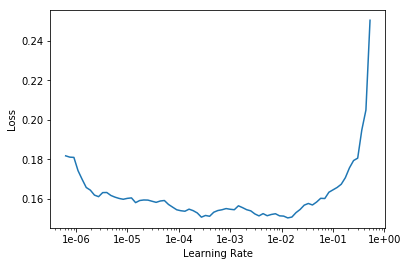

In [18]:
learner.recorder.plot()

In [19]:
learner.fit_one_cycle(2,slice(1e-3,lr/50))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.167878,0.337527,0.926204,20:57
1,0.156481,0.243397,0.937336,20:22


In [20]:
torch.save(learner.model[0].state_dict(),'/kaggle/working/customenc.h5')